In [1]:
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
load_dotenv()
import os
from datetime import datetime, timedelta
from tqdm import tqdm
from processor.processor import Processor as p
from database.adatabase import ADatabase

In [2]:
market = ADatabase("market")
market.connect()
index = market.retrieve("sp500")
market.disconnect()

In [3]:
start = datetime(2024,1,1)
end = datetime.now()

In [29]:
prices = []
date = start
market.connect()
for ticker in tqdm(index["ticker"]):
    try:
        price = market.query("prices",{"ticker":ticker})
        price = p.column_date_processing(price)
        price.sort_values("date",inplace=True)
        prices.append(price)
    except Exception as e:
        print(str(e))
market.disconnect()

 12%|█████████████                                                                                                 | 60/503 [00:16<01:56,  3.82it/s]

'date'


 15%|████████████████▍                                                                                             | 75/503 [00:20<01:52,  3.79it/s]

'date'


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [02:12<00:00,  3.80it/s]

'date'


In [30]:
market_prices = pd.concat(prices)

In [31]:
def calculate_indicators(price, timeframe):
    """Calculate indicators for a single ticker."""
    price = price.sort_values("date")
    price["sma"] = price["adjclose"].rolling(timeframe).mean() / price["adjclose"]
    price["ema"] = price["adjclose"].ewm(span=timeframe, adjust=False).mean() / price["adjclose"]

    delta = price["adjclose"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(timeframe).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(timeframe).mean()
    rs = gain / loss
    price["rsi"] = 100 - (100 / (1 + rs))

    price["std"] = price["adjclose"].rolling(timeframe).std()
    price["bollinger_upper"] = (price["sma"] + 2 * price["std"]) / price["sma"]
    price["bollinger_lower"] = (price["sma"] - 2 * price["std"]) / price["sma"]

    price["pct_change"] = price["adjclose"].pct_change(periods=timeframe)
    price["coev"] = price["adjclose"].rolling(timeframe).std() / price["adjclose"].rolling(timeframe).mean()
    price["year"] = price["date"].dt.year
    price["week"] = [x.week for x in price["date"]]
    price["sell_price"] = price["adjclose"]
    return price.dropna()

In [32]:
signals = ["sma"
           ,"ema","rsi","bollinger_upper","bollinger_lower","pct_change","coev"
          ]
ascendings = [True,False]
timeframes = [5,10,20,60,100]

In [33]:
analysis = []
for timeframe in tqdm(timeframes):
    sim = market_prices.sort_values("date").groupby("ticker").apply(lambda x: calculate_indicators(x,timeframe)).reset_index(drop=True).sort_values("date")
    for signal in signals:
        for ascending in ascendings:
            opportunities = sim[sim["year"]>2012].groupby(["year","week","ticker"]).agg({"date":"last","adjclose":"first","sell_price":"last",signal:"first"}).reset_index()
            trades = opportunities.sort_values(signal,ascending=ascending).groupby(["year","week"]).first().reset_index()
            trades.sort_values("date",inplace=True)
            trades["return"] = trades["sell_price"] / trades["adjclose"]
            trades["pnl"] = trades["return"].cumprod()
            trades["downside"] = trades["pnl"].rolling(100).max() - trades["pnl"]
            analysis.append({
                "timeframe":timeframe,
                "signal":signal,
                "ascending":ascending,
                "pnl":trades["pnl"].iloc[-1],
                "downside":trades["downside"].max(),
                "volatility": trades["return"].std()
            })

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:08<00:00, 73.80s/it]


In [36]:
a = pd.DataFrame(analysis)
a["risk"] = a["downside"] * a["volatility"]
a["rr"] = a["pnl"] / a["volatility"]

In [38]:
a.sort_values("rr",ascending=False).head(10)

,timeframe,signal,ascending,pnl,downside,volatility,risk,rr
59,100,ema,False,2128.690462,721.572684,0.135293,97.623970,15733.890855
24,10,pct_change,True,984.648616,650.462839,0.083889,54.566519,11737.551578
43,60,sma,False,1326.444728,953.177637,0.131379,125.227730,10096.305714
29,20,sma,False,551.002862,147.351113,0.093226,13.737020,5910.370892
38,20,pct_change,True,470.926839,187.706766,0.086318,16.202415,5455.739388
3,5,ema,False,306.454562,92.439162,0.070276,6.496228,4360.746657
15,10,sma,False,336.462176,103.792034,0.081760,8.486021,4115.249744
1,5,sma,False,340.308824,124.820479,0.084649,10.565905,4020.243497
45,60,ema,False,500.993709,296.314459,0.132997,39.408800,3766.967793
17,10,ema,False,276.673001,88.847865,0.081135,7.208685,3410.026262


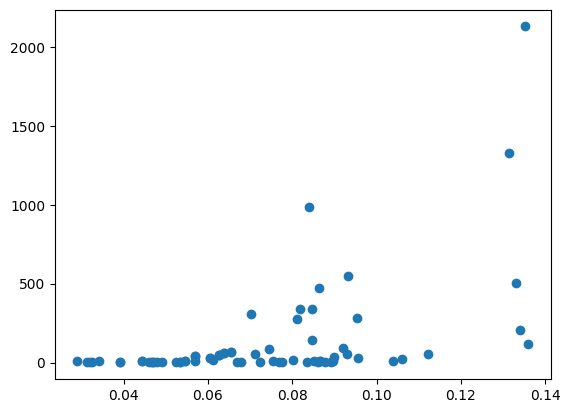

In [40]:
plt.scatter(a["volatility"],a["pnl"])